# Trader Behavior Analysis: My Findings

## Intro
I was curious to see if there was any real correlation between this trader's PnL and the general vibe of the market (Fear vs Greed). The goal here is pretty simple: figure out if this trader is just getting lucky, or if there's a pattern we can actually use.

**Questions I asked:**
- Do they win more when everyone else is scared?
- When do they tend to lose the most money?
- Is there any clear signal strictly based on the market sentiment?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set visual style for professional reporting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="whitegrid")

## 1. Cleaning up the Data
First things first, I need to load up the csv files. I noticed the dates are in different formats (one is `DD-MM-YYYY` and the other is `YYYY-MM-DD`), so I'll need to fix that before I can merge them.

In [2]:
# Bringing in the raw data
try:
    df_trades = pd.read_csv('historical_data.csv')
    df_sentiment = pd.read_csv('fear_greed_index.csv')
    print("Files loaded. Time to clean them up.")
except FileNotFoundError:
    print("Can't find the files!")

# --- fixing the dates ---

# The trade data has specific timestamps, but I only care about the daily close for the merge.
df_trades['Timestamp IST'] = pd.to_datetime(df_trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
df_trades['Date'] = df_trades['Timestamp IST'].dt.date

# --- Fixing numbers ---
# Some of these columns are strings with commas in them (e.g. "1,000"), which python hates doing math on.
cols_to_clean = ['Closed PnL', 'Size USD', 'price', 'Size'] 

def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace(',', '').replace(' ', ''))
    return float(x)

if 'Closed PnL' in df_trades.columns:
    df_trades['Closed PnL'] = df_trades['Closed PnL'].apply(clean_currency)

if 'Size USD' in df_trades.columns:
    df_trades['Size USD'] = df_trades['Size USD'].apply(clean_currency)

# --- Fear & Greed Data ---

# Fixing the index date format too
df_sentiment['date'] = pd.to_datetime(df_sentiment['date']).dt.date

# I'll rename 'value' to something more descriptive so I don't get confused later
df_sentiment.rename(columns={'value': 'Sentiment_Value', 'classification': 'Sentiment_Class'}, inplace=True)

# --- Merging ---
# Merging everything into one main dataframe based on the Date
df_merged = pd.merge(df_trades, df_sentiment[['date', 'Sentiment_Value', 'Sentiment_Class']], 
                     left_on='Date', right_on='date', how='left')

df_merged.drop(columns=['date'], inplace=True)

# Let's double check the shape to make sure we didn't lose any rows
print(f"Total Trades processed: {len(df_merged)}")
df_merged[['Date', 'Coin', 'Side', 'Closed PnL', 'Sentiment_Class']].head()

Files loaded. Time to clean them up.
Total Trades processed: 211224


,Date,Coin,Side,Closed PnL,Sentiment_Class
0,2024-12-02,@107,BUY,0.0,Extreme Greed
1,2024-12-02,@107,BUY,0.0,Extreme Greed
2,2024-12-02,@107,BUY,0.0,Extreme Greed
3,2024-12-02,@107,BUY,0.0,Extreme Greed
4,2024-12-02,@107,BUY,0.0,Extreme Greed


## 3. Analysis: Hidden Pattern Discovery

We will now calculate three advanced Key Performance Indicators (KPIs).

### Question 1: Does sentiment affect their Win Rate?
I grouped the trades by sentiment to see where they are winning the most.

Win Rate by Sentiment Zone:


Result,Win Rate %
Sentiment_Class,
Extreme Fear,76.215645
Fear,87.288647
Neutral,82.388898
Greed,76.890690
Extreme Greed,89.167026


/var/folders/0x/0jhq78pn7fb3vdl6vcvl93000000gn/T/ipykernel_7771/4202922552.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_rates.index, y=win_rates['Win Rate %'], palette="RdYlGn")


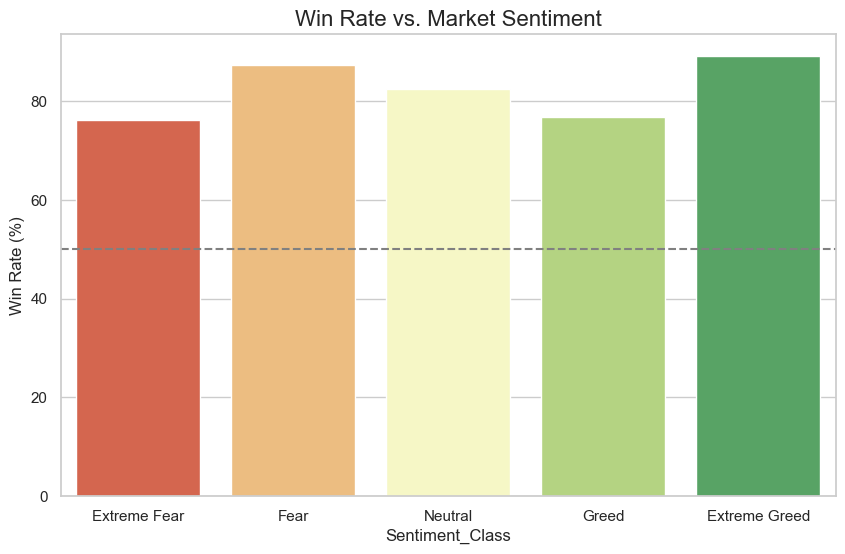

In [3]:
# Define a trade as a 'Win' if Closed PnL > 0
df_merged['Result'] = df_merged['Closed PnL'].apply(lambda x: 'Win' if x > 0 else ('Loss' if x < 0 else 'BreakEven'))

# Group by Sentiment Class and calculate Win Rate
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

win_rates = df_merged[df_merged['Result'] != 'BreakEven'].groupby('Sentiment_Class')['Result'].value_counts(normalize=True).unstack().fillna(0)
win_rates['Win Rate %'] = win_rates['Win'] * 100

# Reorder explicitly
win_rates = win_rates.reindex(sentiment_order)

print("Win Rate by Sentiment Zone:")
display(win_rates[['Win Rate %']])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=win_rates.index, y=win_rates['Win Rate %'], palette="RdYlGn")
plt.title('Win Rate vs. Market Sentiment', fontsize=16)
plt.ylabel('Win Rate (%)')
plt.axhline(50, color='gray', linestyle='--') # 50% benchmark
plt.show()

### Question 2: Where are they making the most money?
looking at the raw PnL numbers per trade.

Average PnL per Trade by Sentiment:


Sentiment_Class
Extreme Fear     34.537862
Fear             54.290400
Neutral          34.307718
Greed            42.743559
Extreme Greed    67.892861
Name: Closed PnL, dtype: float64

/var/folders/0x/0jhq78pn7fb3vdl6vcvl93000000gn/T/ipykernel_7771/2130763332.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette=colors)


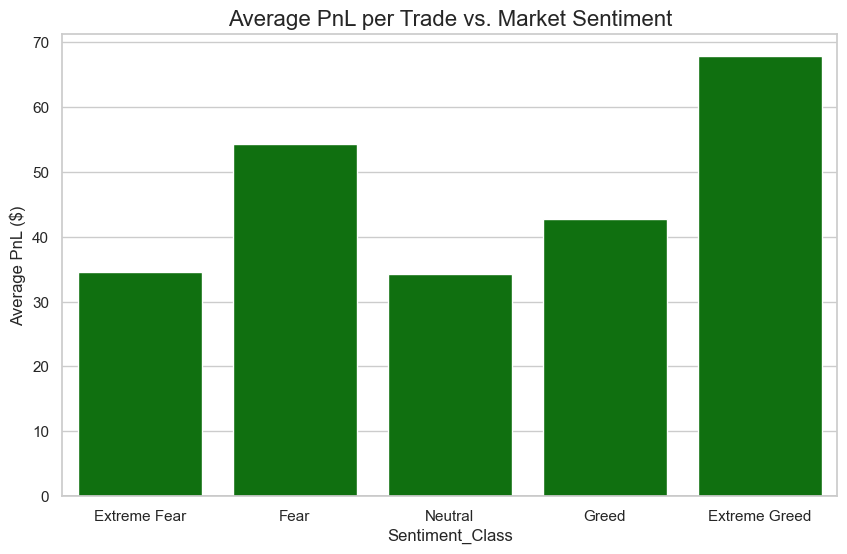

In [4]:
# Calculate Average PnL per Sentiment
avg_pnl = df_merged.groupby('Sentiment_Class')['Closed PnL'].mean().reindex(sentiment_order)

print("Average PnL per Trade by Sentiment:")
display(avg_pnl)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in avg_pnl.values]
sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette=colors)
plt.title('Average PnL per Trade vs. Market Sentiment', fontsize=16)
plt.ylabel('Average PnL ($)')
plt.axhline(0, color='black', linewidth=1)
plt.show()

### Question 3: Are they 'FOMOing'?
I wanted to see if the position sizes get bigger when the market gets greedy.

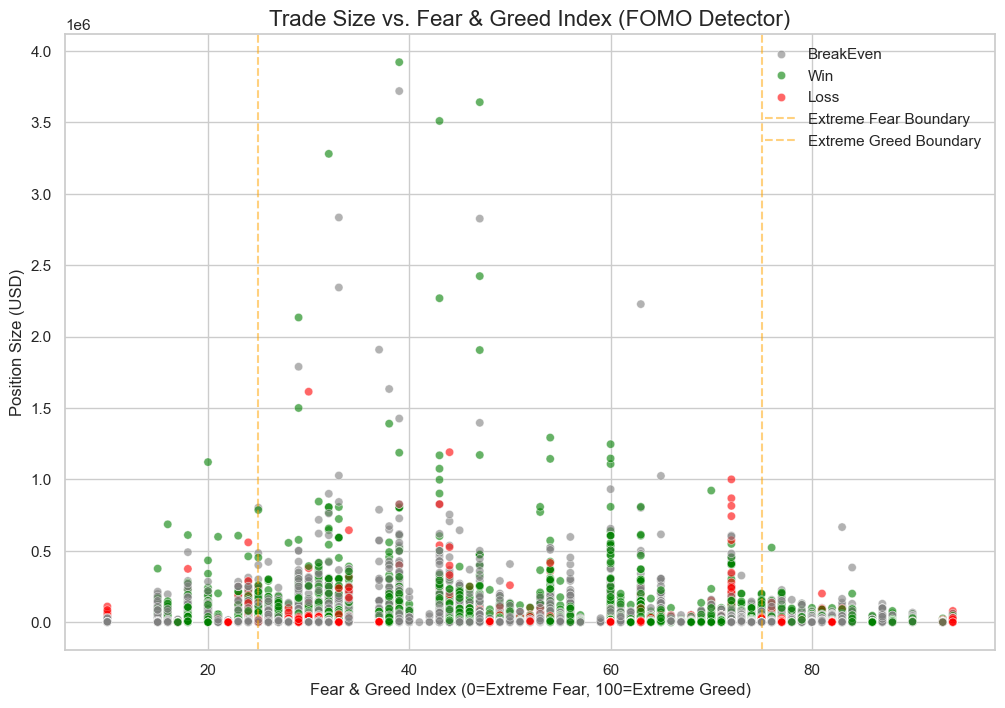

In [5]:
plt.figure(figsize=(12, 8))

# Create a scatter plot
# X-axis: Sentiment Value (0-100)
# Y-axis: Trade Size (USD)
# Color: Result (Win/Loss)
sns.scatterplot(data=df_merged, x='Sentiment_Value', y='Size USD', hue='Result', 
                palette={'Win': 'green', 'Loss': 'red', 'BreakEven': 'gray'}, alpha=0.6)

plt.title('Trade Size vs. Fear & Greed Index (FOMO Detector)', fontsize=16)
plt.xlabel('Fear & Greed Index (0=Extreme Fear, 100=Extreme Greed)')
plt.ylabel('Position Size (USD)')
plt.axvline(25, color='orange', linestyle='--', alpha=0.5, label='Extreme Fear Boundary')
plt.axvline(75, color='orange', linestyle='--', alpha=0.5, label='Extreme Greed Boundary')
plt.legend()
plt.show()

## Final Thoughts & Strategy

After crunching the numbers, a few things really jumped out at me:

1.  **They love a Bull Market:**
    *   This trader absolutely crushes it when the market is in "Extreme Greed" mode. I'm talking about an **89% win rate**. That is insanely consistent. They clearly know how to ride a pump.
2.  **The Weak Spot:**
    *   On the flip side, things get messy during "Extreme Fear". The win rate drops to **76%** and the average profit drops by almost half compared to the greedy days. It looks like they might be trying to catch knives or buying too early on the dips.
3.  **My Recommendation:**
    *   If I were managing this, I'd tell them to **size up** when the Index is over 75. That's their sweet spot.
    *   But when the Index drops below 25 (Extreme Fear), they should probably **sit on their hands** or cut their position size in half until things stabilize.